**Team 1**: Indira Aitkulova, Antonio Azevedo, Alex Chae, Ashley Nguyen


---



**Dataset**: Traffic Crash


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, accuracy_score
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_regression

# Introduction

**Independent Variable**: Driver's sex (female/ non-female)

**Dependent Variable**: Injury rate (number of injured people / total people involved in a crash)

**Hypothesis**: There is a difference in injury rate in crashes with female drivers compared to drivers of other genders.

We aim to measure the influence of the driver's gender on the degree of injury that a car crash causes. In the last milestone, we explored the features we have in the dataset and their relationship to the outcome variable, if any, to identify the features that we should consider along with driver's gender to measure injury rate. Here, we fine-tune the exploratory data analysis from the previous milestone and build various supervised machine learning models with regression and classification using the selected features. Our aim is to see how the driver's sex (`sex` variable) influences the prediction of injury rate. 

# Improving Dependent Variable (Weighted Injury Rate)

In the last milestone, we defined our injury rate as the proportion of people involved in a car crash that got injured, without differentiating different degrees of injuries. To improve upon this definition, we include modify our dependent variable to incorporate different injury levels based on severity by giving different weights. 

In [ ]:
# merged_df=pd.read_csv("/content/drive/My Drive/Colab Notebooks/final_merged_alex.csv") #Indira
#input_path = '/content/drive/My Drive/Junior Spring/Applied Data Science/Project/' #Alex
#merged_df=pd.read_csv(input_path + "final_merged_alex.csv")

In [ ]:
# this is the dataframe that we originally had until now
merged_df.columns

Index(['crash_record_id', 'crash_date', 'device_condition',
       'weather_condition', 'lighting_condition', 'crash_type', 'damage',
       'injuries_total', 'injuries_fatal', 'injuries_incapacitating',
       'injuries_non_incapacitating', 'injuries_reported_not_evident',
       'injuries_no_indication', 'injuries_unknown', 'person_id',
       'person_type', 'sex', 'age', 'safety_equipment', 'airbag_deployed',
       'injury_classification', 'city', 'state', 'vehicle_id', 'make', 'model',
       'vehicle_year', 'vehicle_type', 'unit_type', 'exceed_speed_limit_i',
       'vehicle_defect', 'make_model', 'total_ppl', 'injury_ratio'],
      dtype='object')

From our dataset, we have some columns representing different levels of injuries.

In [ ]:
# columns representing different levels of injuries
merged_df[['injuries_total', 'injuries_fatal', 'injuries_incapacitating','injuries_non_incapacitating', 'injuries_reported_not_evident','injuries_no_indication', 'injuries_unknown']]

,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,injuries_unknown
0,1.0,0.0,0.0,0.0,1.0,2.0,0.0
1,1.0,0.0,0.0,0.0,1.0,2.0,0.0
2,1.0,0.0,0.0,0.0,1.0,2.0,0.0
3,1.0,0.0,0.0,0.0,1.0,2.0,0.0
4,0.0,0.0,0.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...
1800670,0.0,0.0,0.0,0.0,0.0,2.0,0.0
1800671,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1800672,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1800673,0.0,0.0,0.0,0.0,0.0,2.0,0.0


For the new dependent variable, we will give different weights to injuries based on severity. The ranking is as follows in descending order:
1. Fatal injuries
2. Capacitating injuries
3. Non capacitating injuries
4. Not evident injuries
5. Injuries unknown 
6. Injuries_no_indication

Injuries unknown are ranked higher than no indication injuries because injuries unknown is typically used when it is known that some injuries occurred, but there is not enough information available to determine the extent or severity of those injuries while injuries_no_indication" is typically used when there is no information available about whether or not anyone was injured in the event being reported. 


In the below code, we assign different weights to each level of injury rate, ranging between 0 and 1, where 0 indicates the no injury and 1 indiciates the most severe level of injury. The new weighted dependent variable is called `weighted_injury_rate`.


In [ ]:
# Assigning different weights to levels of injury
weights = ({'injuries_fatal': 1.0, 'injuries_incapacitating': 0.8, 
            'injuries_non_incapacitating': 0.6, 'injuries_reported_not_evident': 0.4, 
            'injuries_unknown': 0.2, 'injuries_no_indication': 0})

col_injuries= (['injuries_total', 'injuries_fatal', 'injuries_incapacitating',
                'injuries_non_incapacitating', 'injuries_reported_not_evident',
                'injuries_no_indication', 'injuries_unknown'])

# apply the weights to injury columns 
merged_df['weighted_totals'] = merged_df.apply(lambda row: sum([row[col] * weights[col] for col in weights]), axis=1)

# make the final dependent variable
merged_df['weighted_injury_rate']= (merged_df['weighted_totals'] / merged_df['total_ppl']) * 100

Below is the descriptive statistics of the `weighted_injury_rate` variable. Same as Milestone 2, we can see that a lot of the instances have 0 as the value, as there were no injuries at all. We will see the distribution in more detail in the next section. 

In [ ]:
merged_df['weighted_injury_rate'].describe()

count    1.800675e+06
mean     5.045469e+00
std      1.306084e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+02
Name: weighted_injury_rate, dtype: float64

Now we will modify some of the features that are categorical. As categorical features cannot be used directly as features in a regression model, we will transform them into dummy variables. Below, we create a column for each category in the 4 categorical variables we have. 

In [ ]:
#device conditions
device_conditions = merged_df['device_condition'].dropna().unique().tolist()    # list of different values in 'device_conditions' column
for i in device_conditions:                                                     # make each value a dummy variable 
    merged_df["device_condition_"+i.lower()] = (merged_df["device_condition"] == i).astype(int)

#weather conditions    
weather_conditions = merged_df['weather_condition'].dropna().unique().tolist()
for i in weather_conditions:
    merged_df["weather_condition_"+i.lower()] = (merged_df["weather_condition"] == i).astype(int)

#lightning conditions
lighting_conditions = merged_df['lighting_condition'].dropna().unique().tolist()
for i in lighting_conditions:
    merged_df["lighting_condition_"+i.lower()] = (merged_df["lighting_condition"] == i).astype(int)

#vehicle defects
lighting_conditions = merged_df['vehicle_defect'].dropna().unique().tolist()
for i in lighting_conditions:
    merged_df["vehicle_defect_"+i.lower()] = (merged_df["vehicle_defect"] == i).astype(int)

Hence, our final dataframe is as below. We have 1,800,675 rows and 69 columns in total. The dependent variable is `weighted_injury_rate`, the independent variable is `sex` (coded 1 for females, 0 for nonfemales) and the control variables are `age` (driver's age), `exceed_speed_limit` (whether the car was above the speed limit), `vehicle_defect` (any defects in the vehicle), `device_condition` (condition of the traffic control devices), `weather_condition`, `lighting_condition`, and `vehicle_age` (how old the vehicle was). 

In [ ]:
# input_path="/content/drive/My Drive/Colab Notebooks/" #Indira
# input_path= '/content/drive/MyDrive/EY 2022-2023 Junior/Spring 2023/SOCSC-UH 2214 Applied Data Science/project/m3/' #Ashley
#input_path = '/content/drive/My Drive/Junior Spring/Applied Data Science/Project/' #Alex
input_path = '/content/drive/MyDrive/Applied Data Science/Project/' #Antonio

# load the final dataset
df = pd.read_csv(input_path + "final.csv",low_memory=False)


print(df.shape)
df.head()

(1800675, 69)


,crash_record_id,crash_date,device_condition,weather_condition,lighting_condition,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,...,vehicle_defect_fuel system,vehicle_defect_restraint system,vehicle_defect_cargo,vehicle_defect_trailer coupling,vehicle_defect_exhaust,vehicle_year_value,crash_year,vehicle_age,latitude,longitude
0,79c7a2ce89f446262efd86df3d72d18b04ba487024b7c4...,2019-03-25 14:43:00,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,2017.0,2019,2.0,41.884547,-87.641201
1,79c7a2ce89f446262efd86df3d72d18b04ba487024b7c4...,2019-03-25 14:43:00,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,2010.0,2019,9.0,41.884547,-87.641201
2,79c7a2ce89f446262efd86df3d72d18b04ba487024b7c4...,2019-03-25 14:43:00,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,2017.0,2019,2.0,41.884547,-87.641201
3,79c7a2ce89f446262efd86df3d72d18b04ba487024b7c4...,2019-03-25 14:43:00,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,2010.0,2019,9.0,41.884547,-87.641201
4,792b539deaaad65ee5b4a9691d927a34d298eb33d42af0...,2018-09-05 08:40:00,NO CONTROLS,CLEAR,DAYLIGHT,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,2002.0,2018,16.0,41.968562,-87.740659


In [ ]:
df.columns  # We check that we have all the dummy variables 

Index(['crash_record_id', 'crash_date', 'device_condition',
       'weather_condition', 'lighting_condition', 'injuries_total',
       'injuries_fatal', 'injuries_incapacitating',
       'injuries_non_incapacitating', 'injuries_reported_not_evident',
       'injuries_no_indication', 'injuries_unknown', 'person_id', 'sex', 'age',
       'city', 'state', 'vehicle_id', 'exceed_speed_limit_i', 'vehicle_defect',
       'total_ppl', 'injury_ratio', 'weighted_totals', 'weighted_injury_rate',
       'device_condition_functioning properly', 'device_condition_no controls',
       'device_condition_not functioning',
       'device_condition_functioning improperly', 'device_condition_other',
       'device_condition_worn reflective material', 'device_condition_missing',
       'weather_condition_clear', 'weather_condition_cloudy/overcast',
       'weather_condition_snow', 'weather_condition_rain',
       'weather_condition_freezing rain/drizzle',
       'weather_condition_fog/smoke/haze', 'weather

# Exploratory Data Analysis - Visualization

Because we changed the dependent variable and added some new dummy variables as features, we continue with our exploratory data analysis, mainly through different visualizations. The main change comes in visualizing the distribution of our new dependent variable:

<Axes: xlabel='injury_ratio', ylabel='Count'>

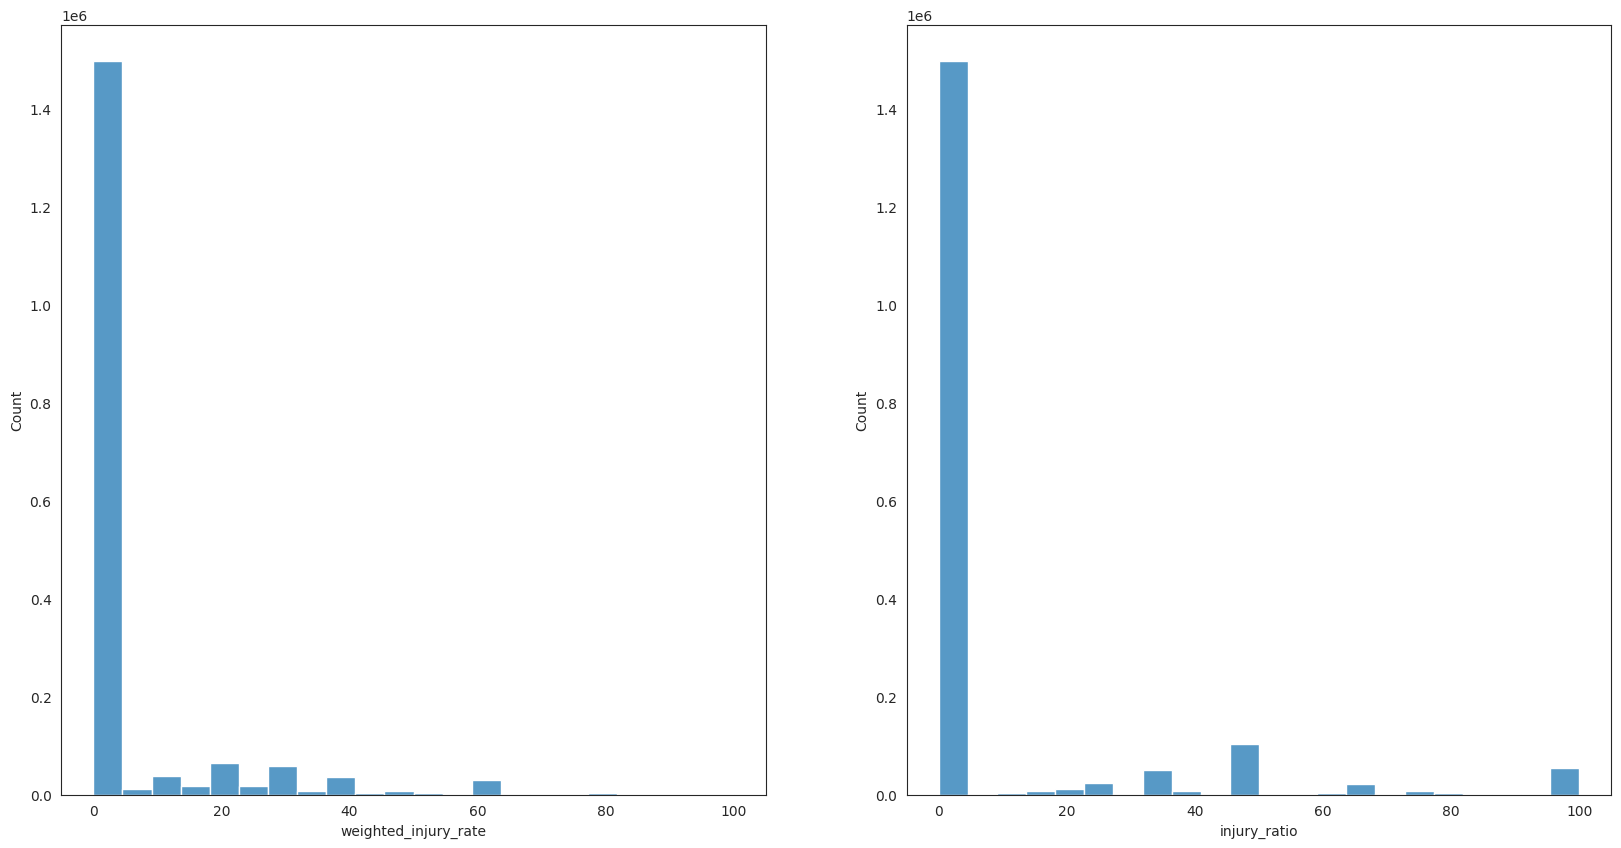

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
sns.histplot(df['weighted_injury_rate'],ax=axs[0])
sns.histplot(df['injury_ratio'],ax=axs[1])

Notice the 0 value dominates the plot. If we want better insight on what the weighted injury rate looks like for accidents that had some form of injury, we can zoom into the non-zero part:

<Axes: xlabel='injury_ratio', ylabel='Density'>

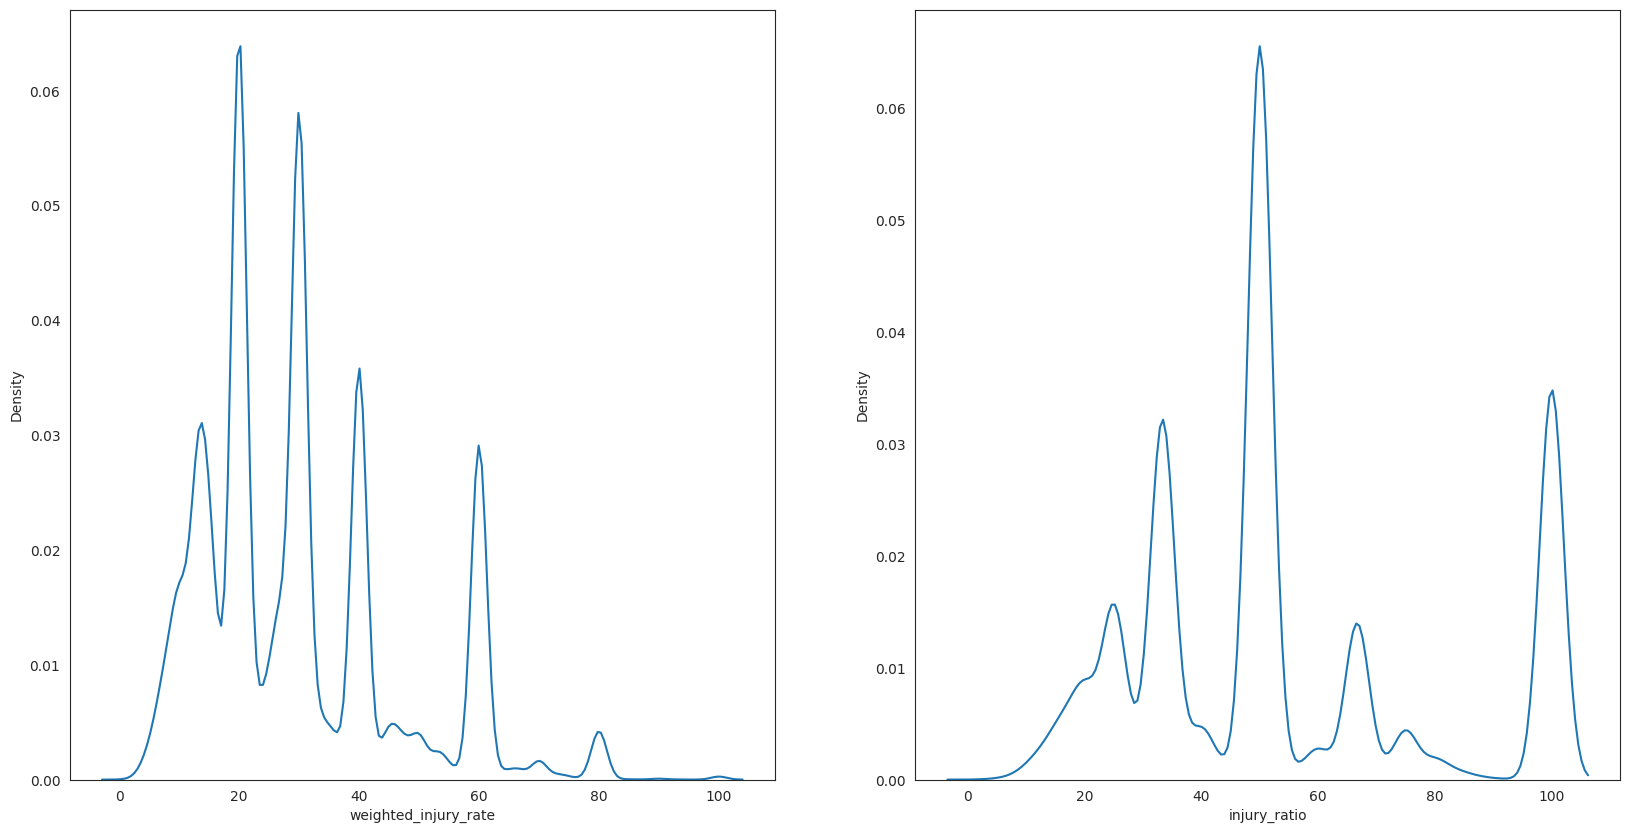

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
sns.kdeplot(df[df['weighted_injury_rate']>0]['weighted_injury_rate'],ax=axs[0])
sns.kdeplot(df[df['injury_ratio']>0]['injury_ratio'],ax=axs[1])

Another way to try to understand the spread of our new dependent variable is through a boxplot, which will show us the interquartile range for all nonzero values:

<Axes: xlabel='injury_ratio'>

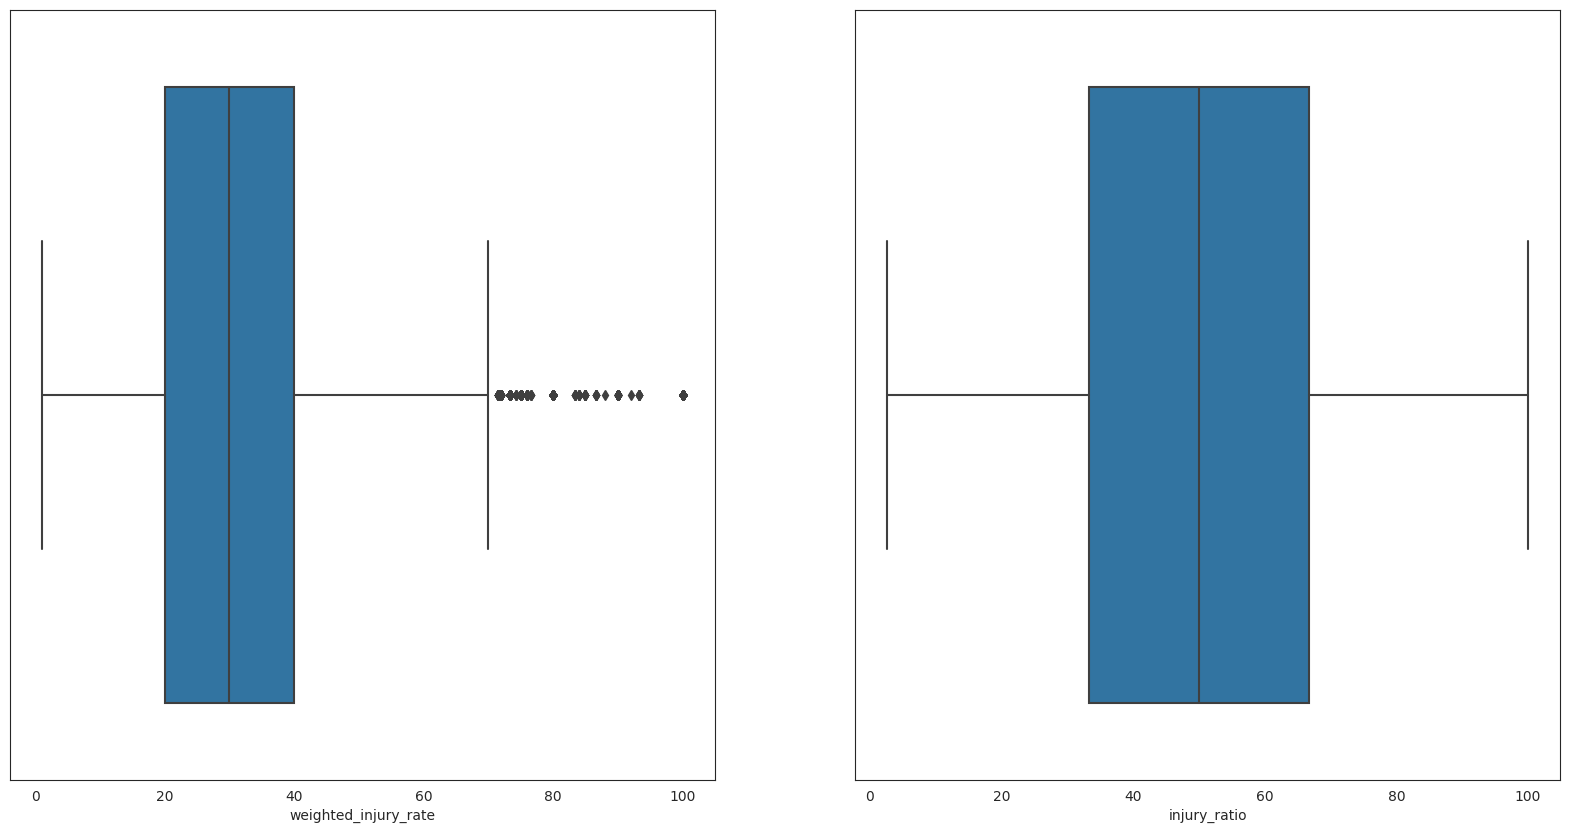

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
sns.boxplot(data=df[df['weighted_injury_rate']>0], x="weighted_injury_rate",ax=axs[0])
sns.boxplot(data=df[df['injury_ratio']>0], x="injury_ratio",ax=axs[1])

From this simple boxplot, we can already notice how values with injury rate larger than about 70% are outliers (heavier accidents are more uncommon), whereas the original variable had a lot of values in the entire range.

One interesting way in which a weighted injury rate might help visualize gender differences is by its geographical disposition in the city of Chicago by gender. We can generate it using the geopandas library as follows:

In [ ]:
# Install necessary libraries
!pip install descartes
!pip install geopandas
!pip install mapclassify

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium
import mapclassify

%matplotlib inline
# Source: 'Mariana, A. (2021, April 15). Geopandas 101: Plot any data with a latitude and longitude on a map.
# Towards Data Science. https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 57.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df.dropna(subset=['longitude', 'latitude'], inplace=True)
df = df[(df['longitude'] != 0) & (df['latitude'] != 0)]
# Import the shapefile of Chicago map
chicago_map = gpd.read_file(input_path+'chicago.shp')
# Prepare the data
geometry1 = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
crs = {'init':'epsg:4326'}
geo_df = gpd.GeoDataFrame(df,
                          crs = crs,
                          geometry = geometry1)

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


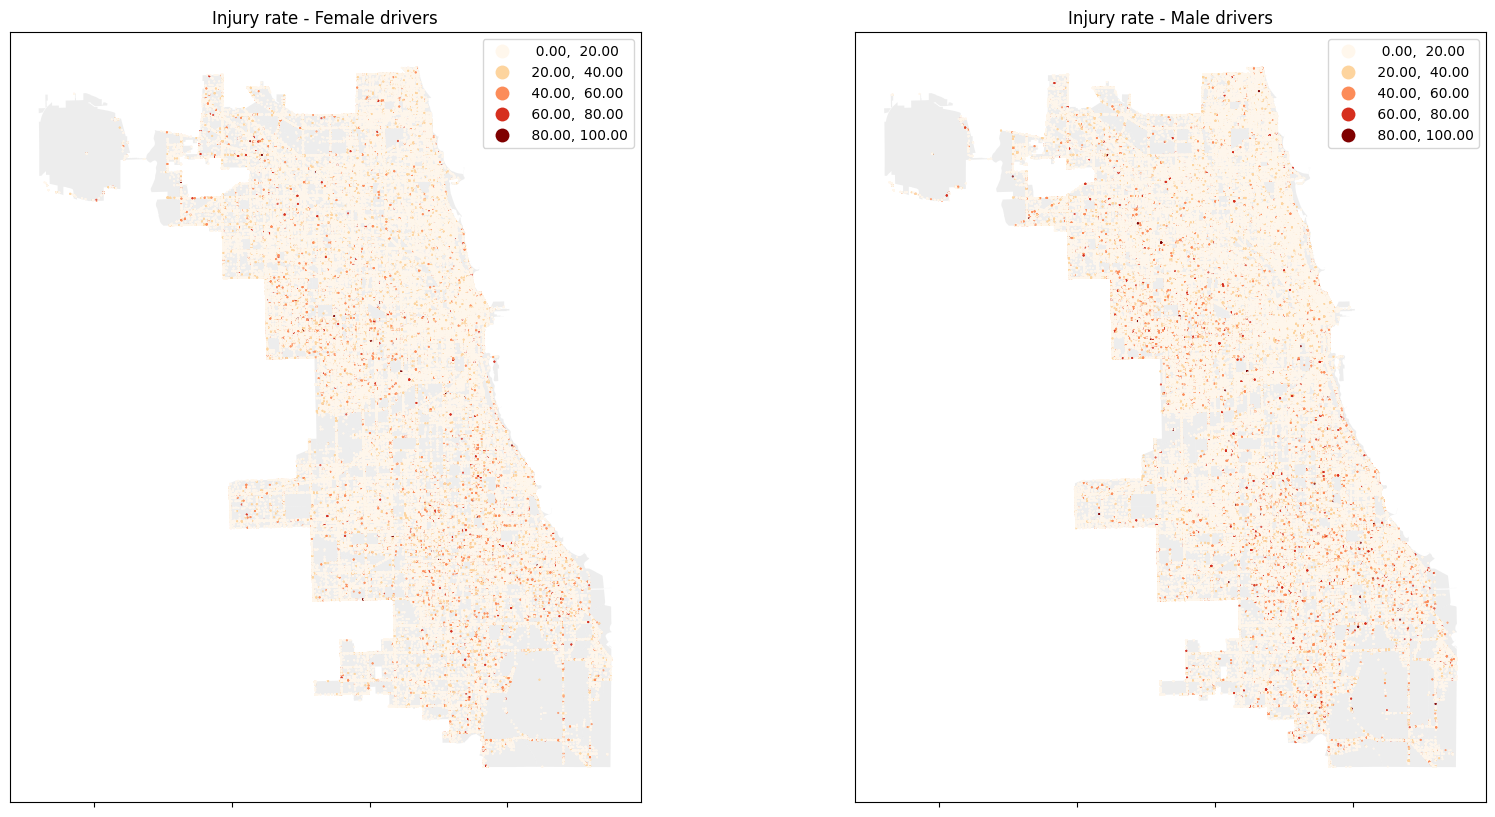

In [ ]:
# Plot with color-coded points based on sex variable
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

chicago_map.plot(ax=axs[0], alpha=0.4, color='lightgrey')
geo_df[geo_df['sex']==1].plot(column='weighted_injury_rate', ax=axs[0],markersize=0.2,scheme='equal_interval', legend=True, cmap='OrRd')
axs[0].set_title('Injury rate - Female drivers')

chicago_map.plot(ax=axs[1], alpha=0.4, color='lightgrey')
geo_df[geo_df['sex']==0].plot(column='weighted_injury_rate', ax=axs[1],markersize=0.2,scheme='equal_interval', legend=True, cmap='OrRd')
axs[1].set_title('Injury rate - Male drivers')

axs[0].tick_params(top=False,bottom = False, labelbottom=False,left=False,right=False, labelleft=False)
axs[1].tick_params(top=False,bottom = False, labelbottom=False,left=False,right=False, labelleft=False)

plt.show()

# Feature Selection 

In total, our dataset has 47 features. However, before running models with all of these features, we conducted feature selection to see if some of them are not necessary. We first collect all the possible features that can influence a model. Then, we'll process them with a train/test split and use scikit's mutual information regression model, which uses an entropy-based approach to compute mutual information between a variable and another. In our case, we'll compute each variable's mutual information with our target variable, the weighted injury rate. 

In [ ]:
# External factor variables
exfac_cols = ['device_condition_functioning properly', 'device_condition_no controls',
       'device_condition_not functioning',
       'device_condition_functioning improperly', 'device_condition_other',
       'device_condition_worn reflective material', 'device_condition_missing',
       'lighting_condition_daylight',
       'lighting_condition_darkness, lighted road',
       'lighting_condition_darkness', 'lighting_condition_dawn',
       'lighting_condition_dusk']

# Weather-related variables 
weather_cols=['weather_condition_clear', 'weather_condition_cloudy/overcast',
       'weather_condition_snow', 'weather_condition_rain',
       'weather_condition_freezing rain/drizzle',
       'weather_condition_fog/smoke/haze', 'weather_condition_other',
       'weather_condition_blowing snow', 'weather_condition_sleet/hail',
       'weather_condition_severe cross wind gate',
       'weather_condition_blowing sand, soil, dirt']

# Vehicle-related variables
vehicles_cols = ['vehicle_age', 'vehicle_defect_none',
       'vehicle_defect_unknown', 'vehicle_defect_brakes',
       'vehicle_defect_other', 'vehicle_defect_tires',
       'vehicle_defect_suspension', 'vehicle_defect_windows',
       'vehicle_defect_lights', 'vehicle_defect_wheels',
       'vehicle_defect_engine/motor', 'vehicle_defect_steering',
       'vehicle_defect_signals', 'vehicle_defect_fuel system',
       'vehicle_defect_restraint system', 'vehicle_defect_cargo',
       'vehicle_defect_trailer coupling', 'vehicle_defect_exhaust',
       'exceed_speed_limit_i']

# People (driver) -related variables
people_cols = ['age','sex']

# Putting all the features together
df_reg = df[['weighted_injury_rate']+ exfac_cols + vehicles_cols + people_cols].dropna()

# Split the data according to the outcome variable
y = df_reg['weighted_injury_rate']
x = df_reg[exfac_cols + vehicles_cols + people_cols]

# Perform train, test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Scale features using normalization
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Compute mutual information between each variable and target variable
mutual_info = mutual_info_regression(x_train, y_train) # takes approx 30 min to run

# Transform into pandas series and sort
mutual_info = pd.Series(mutual_info)
mutual_info.index = x_train.columns
mutual_info.sort_values(ascending=False)

# Save mutual information series
mutual_info.to_csv(input_path+'mutual_info.csv')
mutual_info.sort_values(ascending=False)

We can now visualize the table of features that were cut off and the remaining features, depending on our cutoff rate (more below).


Features cut off:
                                                  0
device_condition_worn reflective material  0.000000
weather_condition_cloudy/overcast          0.000022
weather_condition_freezing rain/drizzle    0.000000
weather_condition_other                    0.000000
weather_condition_sleet/hail               0.000000
weather_condition_severe cross wind gate   0.000000
lighting_condition_dawn                    0.000000
lighting_condition_dusk                    0.000000
vehicle_defect_other                       0.000000
vehicle_defect_engine/motor                0.000000
vehicle_defect_signals                     0.000000
vehicle_defect_restraint system            0.000000
vehicle_defect_cargo                       0.000000

Remaining features:
                                                   0
lighting_condition_darkness                 0.000101
vehicle_defect_exhaust                      0.000144
device_condition_other                      0.000166
weather_condition_fo

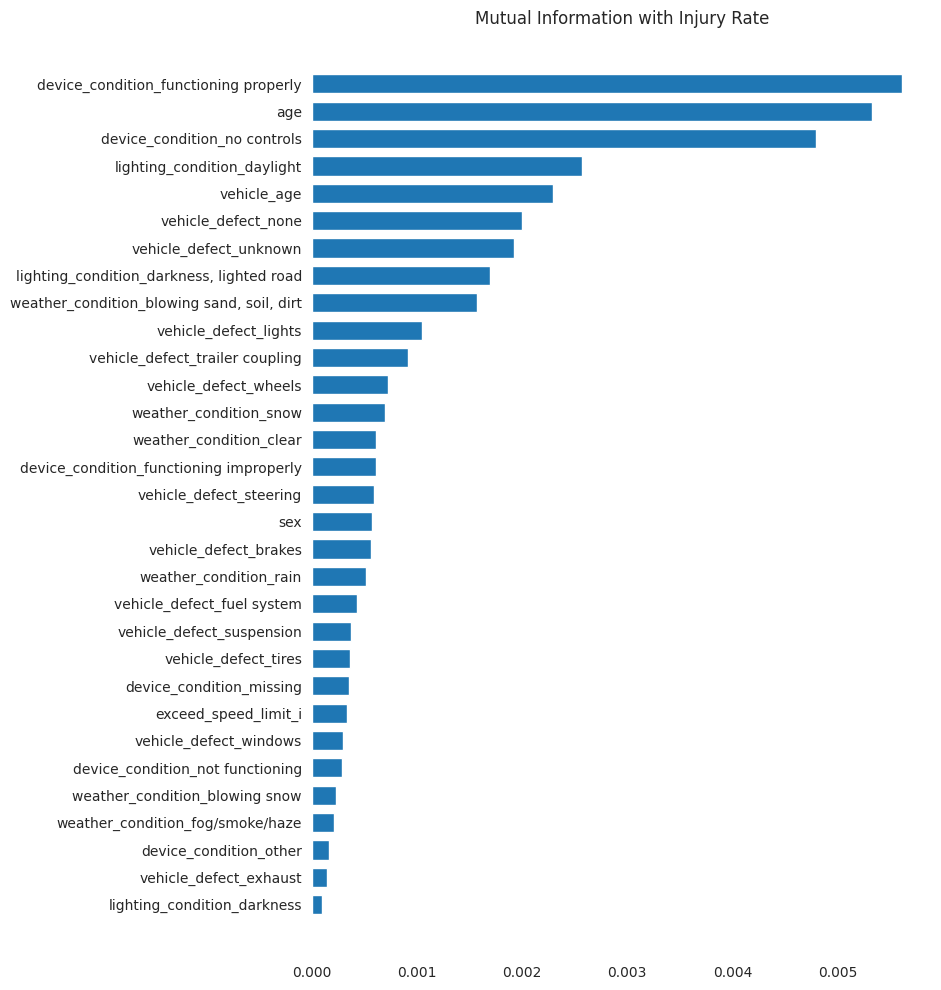

In [ ]:
# Read mutual information
mutual_info = pd.read_csv(input_path+'mutual_info.csv',index_col=0)
mutual_info['0'] = mutual_info['0'].astype('float64')
cutoff = 0.0001 # explanation below

# Generate final data and data that was cut off
cutoff_mutual_info=mutual_info[mutual_info['0']<cutoff]
final_mutual_info=mutual_info[mutual_info['0']>cutoff]

final_mutual_info = final_mutual_info.sort_values(by=['0'],ascending=True)

# Let's plot the information

sns.set_style('white')

fig, ax = plt.subplots(figsize=(8,12))

bars = ax.barh(final_mutual_info.index,final_mutual_info['0'].values,height=0.7)

ax.spines[['left','right', 'top', 'bottom']].set_visible(False)
ax.set_title('Mutual Information with Injury Rate')

# Print data and save
print("\nFeatures cut off:")
print(cutoff_mutual_info)
print("\nRemaining features:")
print(final_mutual_info)

final_mutual_info.to_csv(input_path+'final_mutual_info.csv')

We decided to drop the variables where the mutual information with the target variable feature importance is less than 0.0001. These variables have limited importance in our model and hence for the sake of computation time and parsinomy, we only use variables whose feature importance is more than 0.0001 from the results above. Notice how the most important features have a level of information 50 times higher than the threshold we've used; since information entropy works on a logarithmic scale, this suggests that the low-information features are really almost irrelevant for the output.

Based on that to make further analysis more robust as well as increase speed of the analysis, we will use only features which made 0.0001 cut-off.

In [ ]:
#features_keep = final_mutual_info.index.values.tolist()
#features_keep
features_keep=['device_condition_functioning properly',
 'age',
 'device_condition_no controls',
 'lighting_condition_daylight',
 'vehicle_age',
 'vehicle_defect_none',
 'vehicle_defect_unknown',
 'lighting_condition_darkness, lighted road',
 'weather_condition_blowing sand, soil, dirt',
 'vehicle_defect_lights',
 'vehicle_defect_trailer coupling',
 'vehicle_defect_wheels',
 'weather_condition_snow',
 'weather_condition_clear',
 'device_condition_functioning improperly',
 'vehicle_defect_steering',
 'sex',
 'vehicle_defect_brakes',
 'weather_condition_rain',
 'vehicle_defect_fuel system',
 'vehicle_defect_suspension',
 'vehicle_defect_tires',
 'device_condition_missing',
 'exceed_speed_limit_i',
 'vehicle_defect_windows',
 'device_condition_not functioning',
 'weather_condition_blowing snow',
 'weather_condition_fog/smoke/haze',
 'device_condition_other',
 'vehicle_defect_exhaust',
 'lighting_condition_darkness']

With fewer features, we can also try to visualize a heatmap of pairwise correlations to identify conflations:

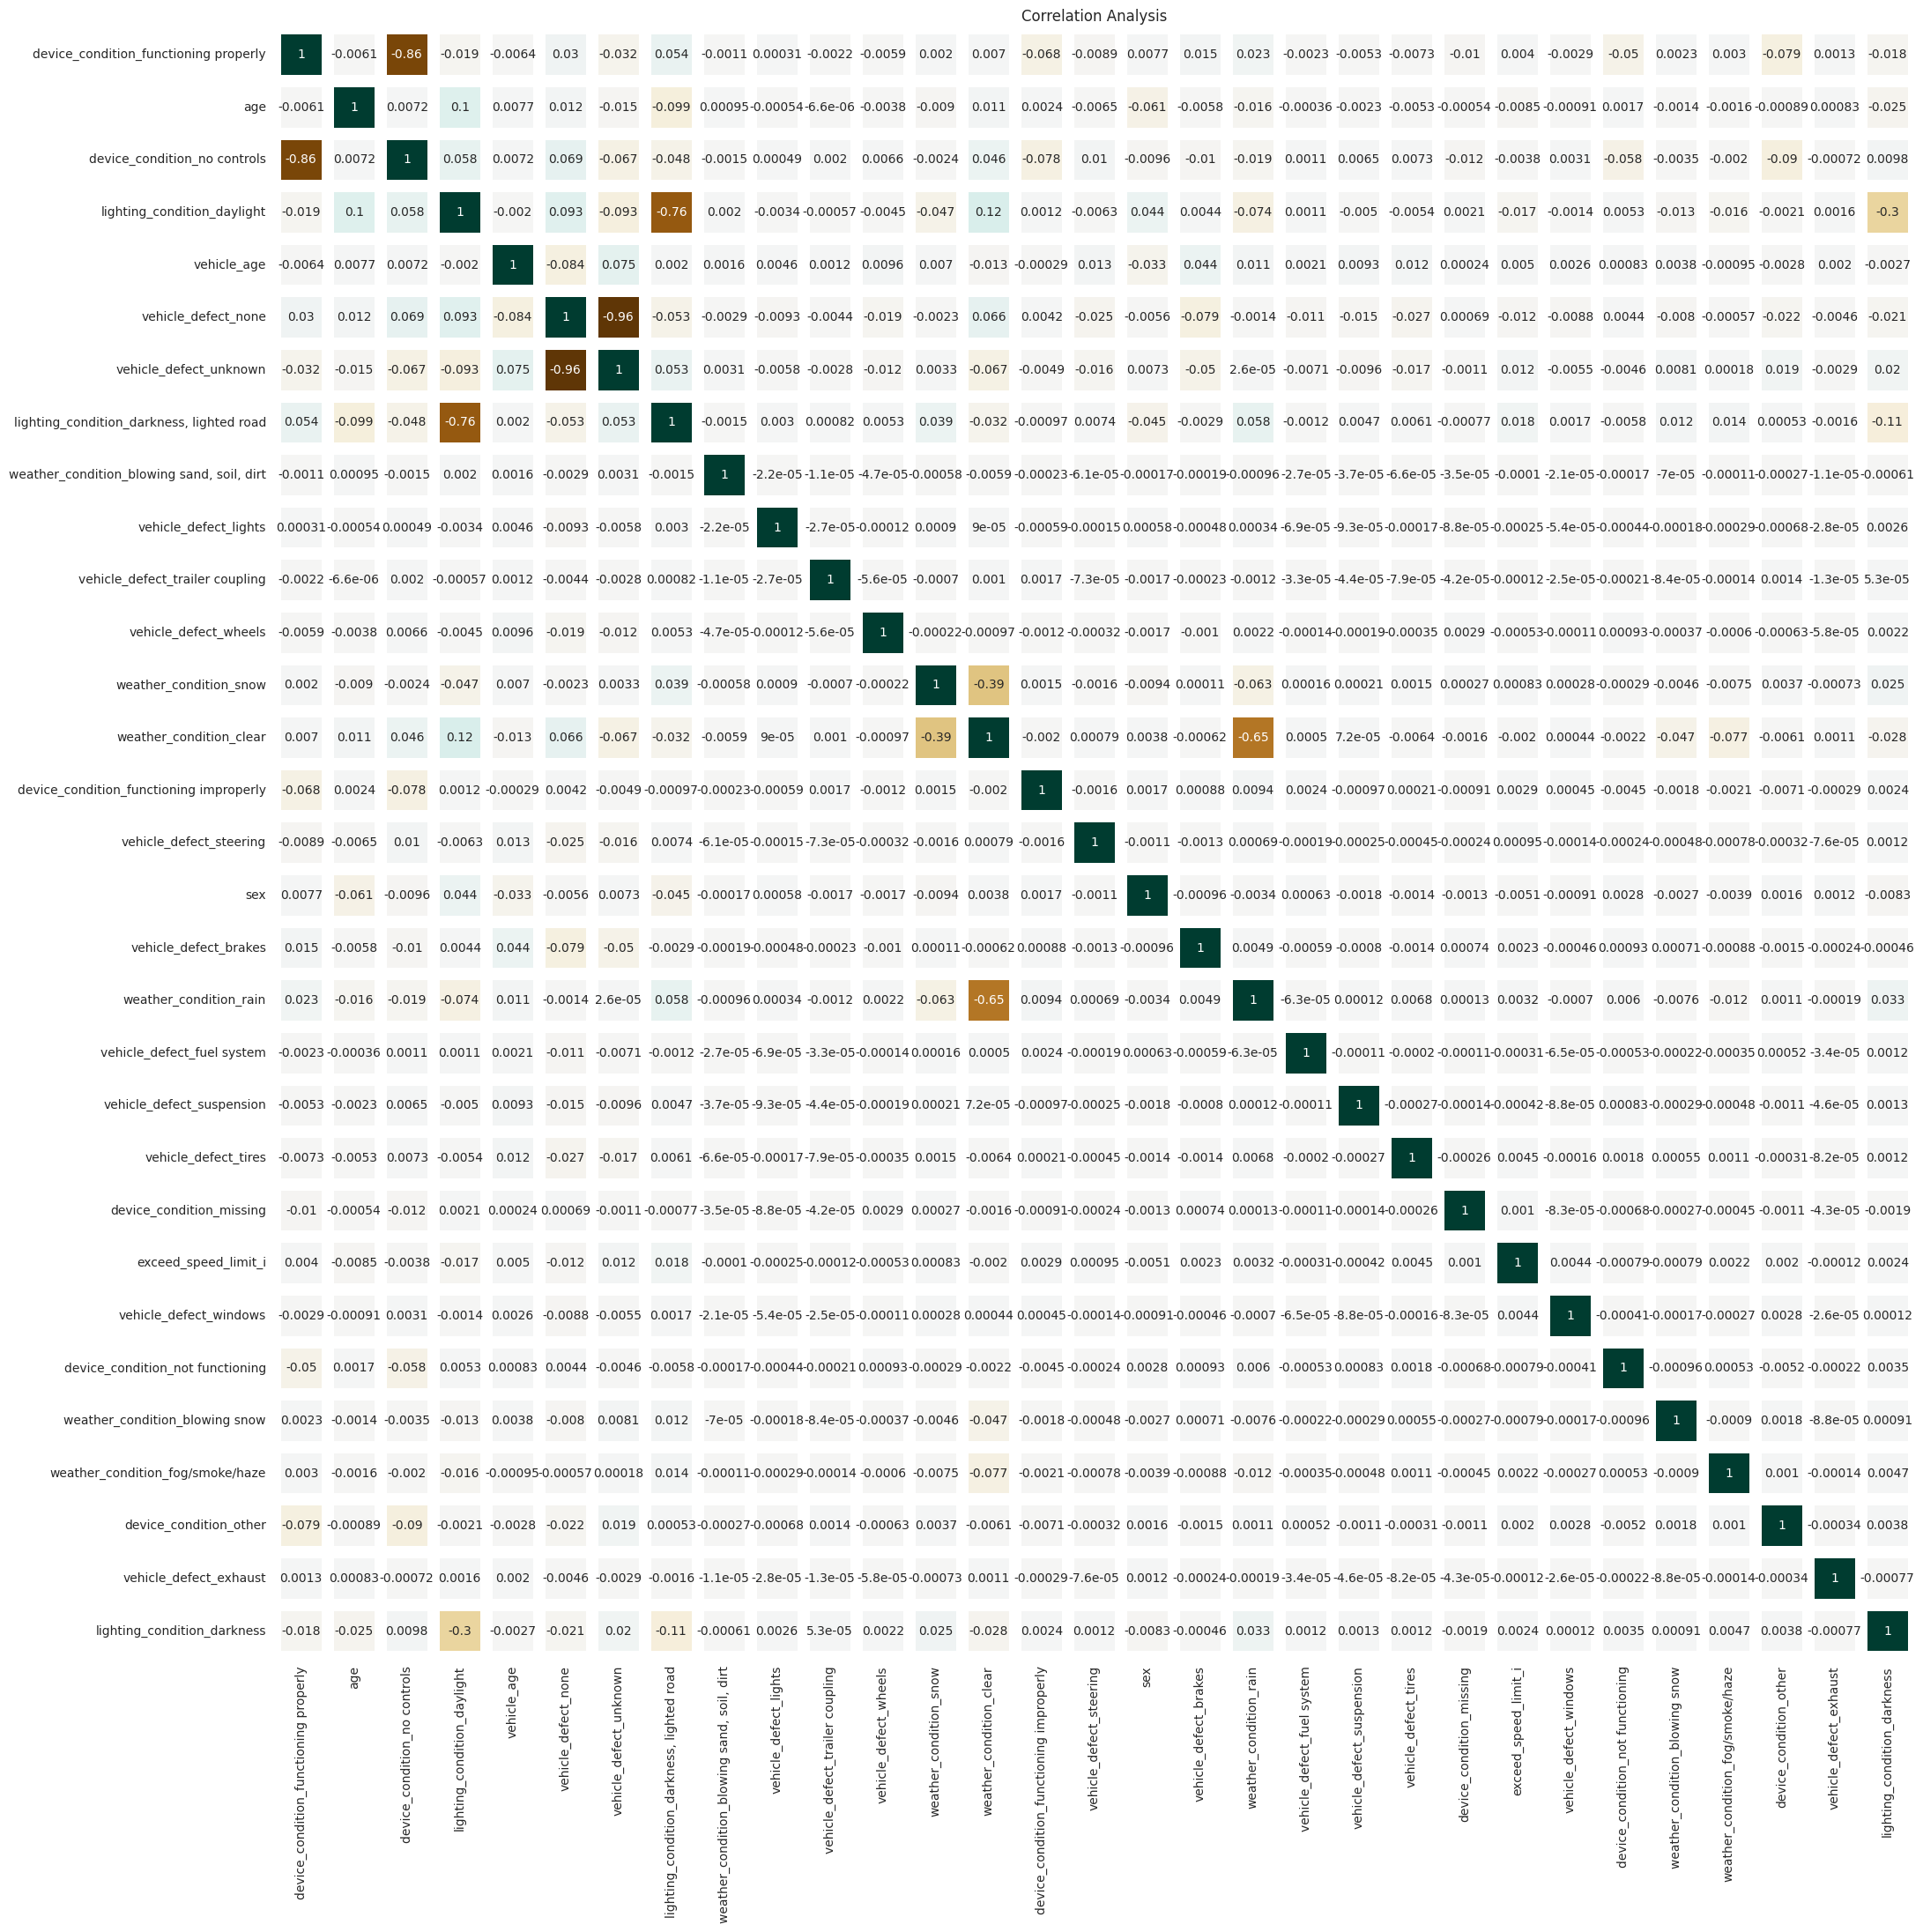

In [ ]:
corrs = df[features_keep].corr()
fig, ax = plt.subplots(figsize=(24,24))
sns.heatmap(corrs,cmap='BrBG',vmin=-1,vmax=1,cbar=False,annot=True,linewidths=10)
# add title
plt.title('Correlation Analysis');

As we can see, apart from some obvious results (such as a vehicle defect being negatively correlated with no vehicle defect), there isn't much conflation between the features. Now, we will use the features that we decided to keep and build machine learning models to see the influence of driver's gender on the weighted injury rate.

# Regression Model

As our outcome variable `weighted_injury_rate` is continuous, we can run a regression model to predict it using the features we have. We split all the data into a train set and a test set. The goal is to make the best model to predict the weighted injury rate using all the features that we have specified as independent variables above. This optimal model can be used to predict the severity of injury of crashes which have real life application in government to provide timely support to the crash scene or insurance companies who want to predict the risk premium for certain age group or sex group.

Details of the model is as follows:

Independent Variables:
1. External Factors: Device condition, Weather, Lighting
2. Vehicle: Age, Defect, Speed Limit
3. People: Age, Sex

Dependent Variable: Weighted Injury Rate

Preprocessing data drops all rows that has NaN values, keeps the features using the mutual information as above and scales features using normalization.

In [ ]:
exfac_cols = ['device_condition_functioning properly','device_condition_no controls',\
              'device_condition_not functioning', 'device_condition_functioning improperly',\
              'device_condition_other','device_condition_missing', 'weather_condition_clear',\
              'weather_condition_snow', 'weather_condition_rain','weather_condition_fog/smoke/haze',\
              'weather_condition_blowing snow', 'weather_condition_blowing sand, soil, dirt',\
              'lighting_condition_daylight', 'lighting_condition_darkness, lighted road',\
              'lighting_condition_darkness']

vehicles_cols = ['vehicle_age', 'vehicle_defect_none',\
                 'vehicle_defect_unknown', 'vehicle_defect_brakes',\
                 'vehicle_defect_tires','vehicle_defect_suspension',\
                 'vehicle_defect_windows','vehicle_defect_lights',\
                 'vehicle_defect_wheels','vehicle_defect_steering',\
                 'vehicle_defect_fuel system','vehicle_defect_trailer coupling',\
                 'vehicle_defect_exhaust','exceed_speed_limit_i']

people_cols = ['age','sex']

df_reg = df[['weighted_injury_rate']+ exfac_cols + vehicles_cols + people_cols].dropna()

y = df_reg['weighted_injury_rate']
x = df_reg[exfac_cols + vehicles_cols + people_cols]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
# Scale features using normalization
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

### Linear Regression

The first model we tried is linear regression, which might not be the best model due to the number of datapoints but it is a good baseline model to compare the performances of other models.

In [ ]:
### Linear Regression
LR = LinearRegression()

param_grid = {
    'fit_intercept': [True, False]}
    
# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(LR, param_grid, cv=5)
grid_search.fit(x_train_scaled, y_train)

# Get the best hyperparameters and fit the model
best_params = grid_search.best_params_
best_LR = LinearRegression(**best_params)
best_LR.fit(x_train_scaled, y_train)
y_pred = best_LR.predict(x_test_scaled)

# Calculate metrics
linreg_mae = mean_absolute_error(y_test,y_pred)
linreg_mse = mean_squared_error(y_test,y_pred)
linreg_r2 = r2_score(y_test,y_pred)

print(f'Mean Absolute Error: {linreg_mae}.\
      \nMean Squared Error: {linreg_mse}.\
      \nR-squared Score: {linreg_r2}.')

Mean Absolute Error: 8.031030849776158.      
Mean Squared Error: 162.61305060301564.      
R-squared Score: 0.01632448617401605.


### Ridge Linear Regression

Ridge linear regression uses L2 regularization to avoid overfitting.
Ridge regression introduces a tuning parameter (alpha) to control the amount of regularization, which balances the model's ability to fit the training data with its ability to generalize to new data.
Ridge regression can handle multicollinearity, which occurs when two or more predictor variables are highly correlated.

In [ ]:
### Ridge Linear Regression
alphas = np.linspace(0.01,3,10)

# Initializing the instance of Ridge
ridge = Ridge()

# Setting parameter grid for grid search
param_grid = {'alpha': alphas}

# defining grid search with 5-fold cross validation
grid_search = GridSearchCV(ridge, param_grid, cv = 5)

# fitting the train
grid_search.fit(x_train_scaled, y_train)

# Printing the best set of parameters
print('Best parameters {}'.format(grid_search.best_params_))

# Finally we train our model on the optimal alpha

linear_ridge_optimal = Ridge(alpha=grid_search.best_params_['alpha'])
linear_ridge_optimal.fit(x_train_scaled, y_train)

# Predict on test set
y_pred = linear_ridge_optimal.predict(x_test_scaled)

# Calculate metrics
ridge_mae = mean_absolute_error(y_test,y_pred)
ridge_mse = mean_squared_error(y_test,y_pred)
ridge_r2 = r2_score(y_test,y_pred)

print(f'Mean Absolute Error: {ridge_mae}.\
      \nMean Squared Error: {ridge_mse}.\
      \nR-squared Score: {ridge_r2}.')

Best parameters {'alpha': 3.0}
Mean Absolute Error: 8.031071148240251.      
Mean Squared Error: 162.61285460529766.      
R-squared Score: 0.01632567179937172.


### Lasso Linear Regression

Lasso linear regression uses L1 regularization, which adds a penalty term to the cost function of linear regression. This penalty term encourages sparsity in the coefficients of the regression model, which means it shrinks some coefficients to zero. 

The coefficient estimates of Lasso regression tend to be more robust to multicollinearity compared to simple linear regression. However, as tested in Milestone 2, our dataset does not have high degree of multicollinearity (vif value was approximately 1). Therefore, the metrics of Ridge and Lasso linear regression models did not improve significantly from the base linear regression model.

In [ ]:
### Lasso Linear Regression
alphas = np.linspace(0.01,1.5,5)

# Initializing the instance of Lasso
lasso = Lasso()

# Setting parameter grid for grid search
param_grid = {'alpha': alphas}

# defining grid search with 5-fold cross validation
grid_search = GridSearchCV(lasso, param_grid, cv = 5)

# fitting the train
grid_search.fit(x_train_scaled, y_train)

# Printing the best set of parameters
print('Best parameters {}'.format(grid_search.best_params_))

# Finally we train our model on the optimal alpha

linear_lasso_optimal = Lasso(alpha=grid_search.best_params_['alpha'])
linear_lasso_optimal.fit(x_train_scaled, y_train)

# Predict on test set
y_pred = linear_lasso_optimal.predict(x_test_scaled)

# Calculate metrics
lasso_mae = mean_absolute_error(y_test,y_pred)
lasso_mse = mean_squared_error(y_test,y_pred)
lasso_r2 = r2_score(y_test,y_pred)

print(f'Mean Absolute Error: {lasso_mae}.\
      \nMean Squared Error: {lasso_mse}.\
      \nR-squared Score: {lasso_r2}.')

Best parameters {'alpha': 0.01}
Mean Absolute Error: 8.05222366030545.      
Mean Squared Error: 162.80963239506278.      
R-squared Score: 0.015135327649631214.


### Linear SVM Regression

Linear SVM Regression finds the line that has the maximum margin (distance) from the closest data points and is more robust to outliers. While the R square is worse than linear regression, the MAE is significantly lower. 

In [ ]:
### Linear SVM Regression
from sklearn.svm import LinearSVR

# Set the hyperparameters to tune
param_grid = {'C': [0.1, 1, 10]}

# Create an instance of the SVR model
svr = LinearSVR()

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(svr, param_grid, cv=5)
grid_search.fit(x_train_scaled, y_train)

# Printing the best set of parameters
print('Best parameters {}'.format(grid_search.best_params_))

# Get the best hyperparameters and fit the model
best_params = grid_search.best_params_
best_svr = LinearSVR(**best_params)
best_svr.fit(x_train_scaled, y_train)
y_pred = best_svr.predict(x_test_scaled)

# Calculate metrics
svr_mae = mean_absolute_error(y_test, y_pred)
svr_mse = mean_squared_error(y_test, y_pred)
svr_r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {svr_mae}.\
      \nMean Squared Error: {svr_mse}.\
      \nR-squared Score: {svr_r2}.')

Best parameters {'C': 10}
Mean Absolute Error: 4.901510555749394.      
Mean Squared Error: 189.2921588550866.      
R-squared Score: -0.14506222553796655.


### Decision Tree Regression

Decision tree regression can model nonlinear relationships, but maybe because there are too many similar clusters in our dataset, the R-square is not as high as linear regression and the MAE and MSE are worse than linear regression.

In [ ]:
# Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor

# Define the parameter grid to search over
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10]
}

# Create an instance of the decision tree regressor model
dt = DecisionTreeRegressor()

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(dt, param_grid, cv=5)
grid_search.fit(x_train_scaled, y_train)

# Printing the best set of parameters
print('Best parameters {}'.format(grid_search.best_params_))

# Get the best hyperparameters and fit the model
best_params = grid_search.best_params_
best_dt = DecisionTreeRegressor(**best_params)
best_dt.fit(x_train_scaled, y_train)
y_pred = best_dt.predict(x_test_scaled)

# Calculate metrics
dt_mae = mean_absolute_error(y_test, y_pred)
dt_mse = mean_squared_error(y_test, y_pred)
dt_r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {dt_mae}.\
      \nMean Squared Error: {dt_mse}.\
      \nR-squared Score: {dt_r2}.')

Mean Absolute Error: 8.04050854406083.      
Mean Squared Error: 162.67717661329857.      
R-squared Score: 0.015936576434417926.


## Regression Model Performance Summary

The linear SVM regression model has the lowest mean absolute error (MAE) of 4.901, indicating that it has the best performance in predicting the target variable compared to the other models.

The R-squared (R2) scores are all very low, indicating that the models have poor performance in explaining the variability of the weighted injury rate. The linear SVM regression model has a negative R2 score, which indicates that the model fits the data worse than a horizontal line. 

In conclusion, the linear SVM regression model has the best performance in predicting the weighted injury rate. So if we want to use the model just for predicting, we should use Linear SVM with the lowest MAE score. If we want to study the variability of the weighted injury rate, we should use linear ridge regression with highest R square.

In [ ]:
### Make a dataframe and report the metrics for 5 models
metrics_dict = {
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Linear SVM Regression', 'Decision Tree Regression'],
    'MAE': [linreg_mae, ridge_mae, lasso_mae, svr_mae, dt_mae],
    'MSE': [linreg_mse, ridge_mse, lasso_mse, svr_mse, dt_mse],
    'R2': [linreg_r2, ridge_r2, lasso_r2, svr_r2, dt_r2]
}
metrics = pd.DataFrame(metrics_dict).T
metrics

,0,1,2,3,4
Model,Linear Regression,Ridge Regression,Lasso Regression,Linear SVM Regression,Decision Tree Regression
MAE,8.031031,8.031071,8.052224,4.901446,8.040509
MSE,162.613051,162.612855,162.809632,189.328052,162.677177
R2,0.016324,0.016326,0.015135,-0.145279,0.015937


## Importance of driver's gender - Linear SVM Regression

To further study the feature importance of driver's gender, we will use Linear SVM model to compare the importance of gender with different set of control variables.

In [ ]:
# Model 1: gender and weighted injury rate
x1 = scaler.fit_transform(x[['sex']])
svm1 = LinearSVR(C=10).fit(x1, y)
importance1 = svm1.coef_
df_importance1 = pd.DataFrame({'Feature': ['sex'], 'Importance': importance1})

# Model 2: gender, sex, and weighted injury rate
x2 = scaler.fit_transform(x[['sex'] + exfac_cols])
svm2 = LinearSVR(C=10).fit(x2, y)
importance2 = svm2.coef_
df_importance2 = pd.DataFrame({'Feature': ['sex'] + exfac_cols, 'Importance': importance2})

# Model 3: people and vehicles_col and weighted injury rate
x3 = scaler.fit_transform(x[['sex'] + vehicles_cols + exfac_cols])
svm3 = LinearSVR(C=10).fit(x3, y)
importance3 = svm3.coef_
df_importance3 = pd.DataFrame({'Feature': ['sex'] + vehicles_cols + exfac_cols, 'Importance': importance3})

# Model 4: exfac_cols, vehicles_cols, people_cols, and weighted injury rate
x4 = scaler.fit_transform(x[['sex'] + exfac_cols + vehicles_cols + ['age']])
svm4 = LinearSVR(C=10).fit(x4, y)
importance4 = svm4.coef_
df_importance4 = pd.DataFrame({'Feature': ['sex'] + exfac_cols + vehicles_cols + ['age'], 'Importance': importance4})

In [ ]:
df_all = pd.merge(df_importance1, df_importance2, on='Feature', how='outer', suffixes=('_1', '_2'))
df_all = pd.merge(df_all, df_importance3, on='Feature', how='outer')
df_all = pd.merge(df_all, df_importance4, on='Feature', how='outer', suffixes=('_3', '_4'))

df_all

,Feature,Importance_1,Importance_2,Importance_3,Importance_4
0,sex,1.522140e-12,3.570802e-09,-3.240841e-06,-0.000037
1,device_condition_functioning properly,NaN,1.688639e-08,1.417907e-06,0.000531
2,device_condition_no controls,NaN,1.574226e-08,9.574031e-07,0.000574
3,device_condition_not functioning,NaN,-5.709460e-09,4.278603e-07,0.006540
4,device_condition_functioning improperly,NaN,-3.025176e-09,5.353746e-07,0.002383
5,device_condition_other,NaN,8.332149e-08,7.439285e-07,0.000521
6,device_condition_missing,NaN,-2.930051e-07,2.670392e-06,-0.000094
7,weather_condition_clear,NaN,-1.155552e-08,-4.160421e-07,0.000155
8,weather_condition_snow,NaN,-2.312108e-08,-2.148397e-07,-0.000033
9,weather_condition_rain,NaN,-1.078172e-08,2.729084e-06,-0.000301


# Classification Model

The regression model above showed gender as a feature influences predictions of injury rate. Recall that the outcome variable `weighted_injury_rate` in our dataset includes a lot of 0 values, meaning that there are a lot of crashes that ended in no injuries at all. Using this, we will next build a classification model to predict whether a car crash results in any injuries or not and how gender plays a role here. Below is a quick analysis of the proportion of crashes with no injuries. 

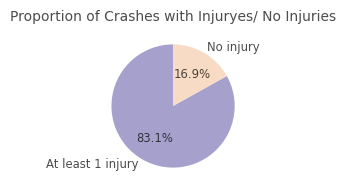

In [ ]:
injury_noinjury = df['weighted_injury_rate'] > 0
injury_ratio = injury_noinjury.value_counts(normalize = True)

# Plot as a pie chart
fig, ax = plt.subplots(1, 1, figsize = (4, 2))
ax.pie(injury_ratio, labels = ["At least 1 injury", "No injury"], colors =["#a6a1cc", "#f8dbc4"], startangle=90, autopct='%1.1f%%', textprops={'fontsize': "small", 'alpha': 0.7})
plt.title("Proportion of Crashes with Injuryes/ No Injuries", alpha=0.7, fontsize="medium");

As 83.1% of the crashes in our dataset resulted in no injuries, we have enough instances to build a binary classification model to predict whether a car crash will result in any injuries or not. We start by dividing the instances into those that resulted in injuries (coded '1') and those that did not (coded '0'). `any_injuries` is the column reflecting this information.  

In [ ]:
# make any_injuries column 
df['any_injuries'] = np.where(df['weighted_injury_rate']>0, 1, 0)

# check that the distribution of 0 and 1 is the same as the pie chart above
df['any_injuries'].value_counts(normalize = True) # It is the same! 

0    0.831047
1    0.168953
Name: any_injuries, dtype: float64

We start by creating another dataframe df_class which contains only the columns needed for Classification.

In [ ]:
# List of features
exfac_cols = ['device_condition_functioning properly', 'device_condition_no controls',
       'device_condition_not functioning',
       'device_condition_functioning improperly', 'device_condition_other',
       'device_condition_missing',
       'lighting_condition_daylight',
       'lighting_condition_darkness, lighted road',
       'lighting_condition_darkness']
weather_cols=['weather_condition_clear', 'weather_condition_cloudy/overcast',
       'weather_condition_snow', 'weather_condition_rain',
       'weather_condition_fog/smoke/haze',
       'weather_condition_blowing snow', 
       'weather_condition_blowing sand, soil, dirt']

vehicles_cols = ['vehicle_age', 'vehicle_defect_none',
       'vehicle_defect_unknown', 'vehicle_defect_brakes',
       'vehicle_defect_tires',
       'vehicle_defect_suspension', 'vehicle_defect_windows',
       'vehicle_defect_lights', 'vehicle_defect_wheels',
       'vehicle_defect_steering', 'vehicle_defect_fuel system',
       'vehicle_defect_trailer coupling', 'vehicle_defect_exhaust',
       'exceed_speed_limit_i']

people_cols = ['age','sex']

# vehicle_age variable has many NaNs. We impute with median, because it is skewed
df['vehicle_age'].fillna(df['vehicle_age'].median(), inplace= True)

# Make a dataframe with only the variables we need for classification
df_class = df[['any_injuries']+ exfac_cols + vehicles_cols +weather_cols + people_cols].dropna()

In [ ]:
# Outcome variable that we want to predict
y = df_class['any_injuries']

# Feature variables except for `sex`
X = df_class.drop(['any_injuries'], axis=1)

# Train-test split with 80% training and 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Linear SVM Classification

First, we try the Linear Support Vector Machine classification model with the same features to predict `any_injuries`. We conduct a 3-fold cross validation grid search with different `C` parameters to find the degree of L2 regularization that provides the best model. 

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
# This takes 1hr 30min to run 

c_params = {'C': [0.1, 1, 5]}

svm= LinearSVC()
svm_grid = GridSearchCV(estimator= svm, param_grid = c_params, cv=3)
svm_grid.fit(X_train, y_train)


print('Best parameters {}'.format(svm_grid.best_params_))
print('Best score {}'.format(svm_grid.best_score_))

pd.DataFrame(svm_grid.cv_results_)

Run locally in another computer, the above GridSearch printed the following outcome: 
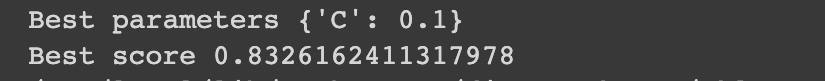

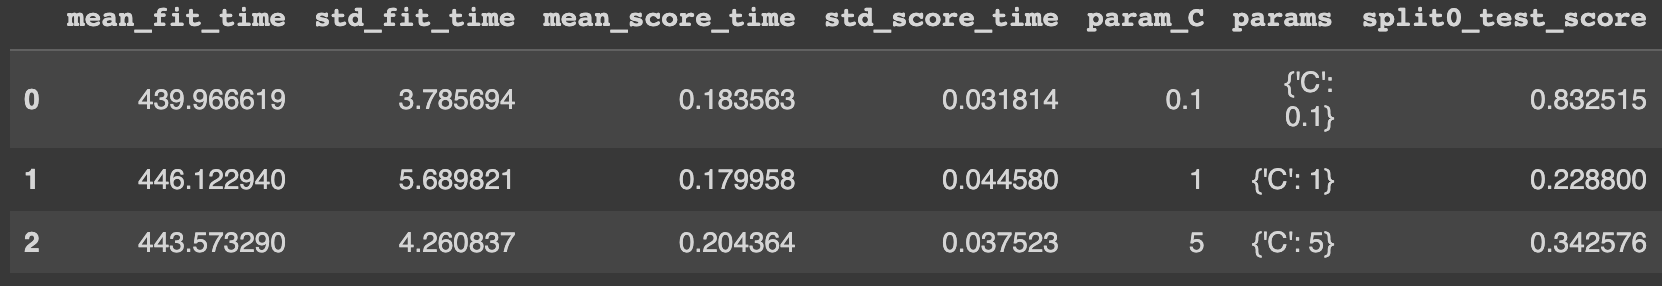

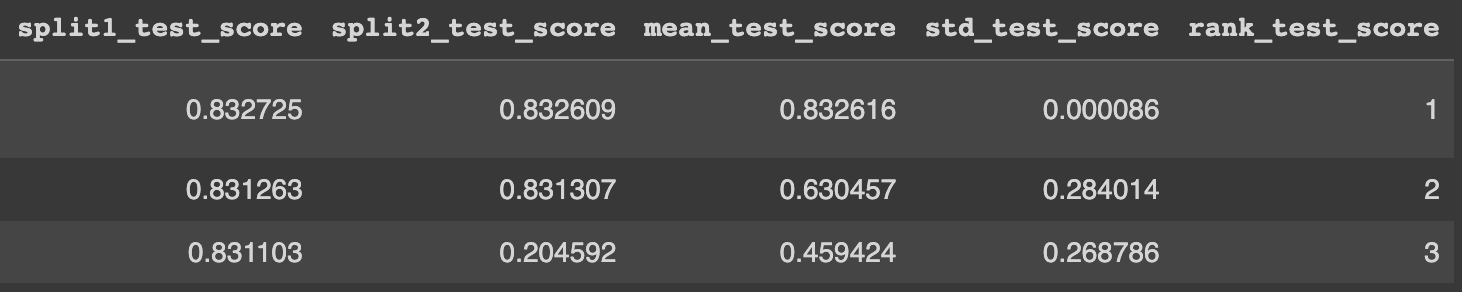

From the GridSearch results, we can see that C=0.1 was chosen to be the best parameter. It had a much higher mean test score than the other parameters and also the lowest standard deviation in the test score. Hence, we can confidently use 0.1 as the C parameter in the model. 

In [ ]:
# Build a Linear SVM Classification model using the best parameters found by GridSearch
svmclas = LinearSVC(C= 0.1)
svmclas.fit(X_train, y_train)

y_pred= svmclas.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Below, we report the evaluation metrics for this model. We will return to the evaluation results in the next sections.

In [ ]:
svm_prec = precision_score(y_pred, y_test)
svm_recall = recall_score(y_pred, y_test)
svm_auc = roc_auc_score(y_pred, y_test)
svm_acc= svmclas.score(X_test, y_test)

print('Test Precision {}'.format(svm_prec))
print('Test Recall {}'.format(svm_recall))
print('Test AUC-ROC {}'.format(svm_auc))
print('Test Accuracy {}'.format(svm_acc))

Test Precision 0.044176113027764086
Test Recall 0.5571902196435972
Test AUC-ROC 0.6967213042047161
Test Accuracy 0.8325128076971136


## Logistic Regression
We also tried logistic regression for classification. Logistic Regression is appropriate for binary classification problems, such as predicting whether a crash had an injury or not. This algorithm is well-suited for situations where the target variable is binary and the features are continuous or categorical. Logistic regression also provides interpretable coefficients, which allow us to understand the relationship between the predictor variables and the outcome.

In [ ]:
#First for logistic regression we need to split the data and make sure that the split on injuries and not injurues is the same across train and test
x = df[features_keep]
y = df['any_injuries']

# train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=0) #to insure equal split

# Feature scaling with normalization 
scaler1=MinMaxScaler()  #age and vehcile age are not normally distributed

cont=['vehicle_age', 'age']
binary=[i for i in features_keep if i not in cont]

x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()
x_train_normal = pd.DataFrame(scaler1.fit_transform(x_train[cont]), columns=cont).reset_index(drop=True)
x_train_binary=pd.DataFrame((x_train[binary]), columns=binary).reset_index(drop=True)
x_train_scaled = pd.concat([x_train_normal, x_train_binary], axis=1).reset_index(drop=True)

x_test_normal = pd.DataFrame(scaler1.transform(x_test[cont]), columns=cont).reset_index(drop=True)
x_test_binary=pd.DataFrame((x_test[binary]), columns=binary).reset_index(drop=True)
x_test_scaled = pd.concat([x_test_normal, x_test_binary], axis=1).reset_index(drop=True) 

In [ ]:
# Making logistic regression
from sklearn.metrics import accuracy_score, r2_score

def model_logit(x_train, y_train, x_test, y_test):
    C_range = [0.01, 0.1, 1, 10]  # range of C parameters to try in GridSearch 
    param_grid = {"C": C_range}

    logreg = LogisticRegression(penalty="l2", max_iter=1000)  #we use l2 because best features are already selected
    logreg_cv = GridSearchCV(param_grid=param_grid, estimator=logreg, cv=3, scoring="accuracy")
    logreg_cv.fit(x_train, y_train)

    y_pred=logreg_cv.predict(x_test)

    print(logreg_cv.best_params_)
    
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

print(model_logit(x_train_scaled, y_train, x_test_scaled,y_test))

The GridSearch results in the following when run locally in another computer:
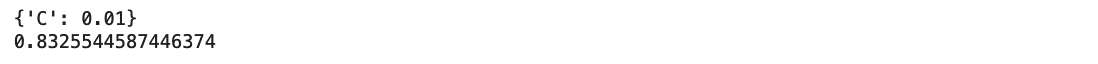

Based on that, we will train the model using C=0.01 and reporting the necessary metrics.

In [ ]:
logreg = LogisticRegression(penalty="l2", max_iter=1000, C=0.01)
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)

In [ ]:
logreg_prec = precision_score(y_pred, y_test)
logreg_recall = recall_score(y_pred, y_test)
logreg_auc = roc_auc_score(y_pred, y_test)
logreg_acc= logreg.score(x_test, y_test)

print('Test Precision {}'.format(logreg_prec))
print('Test Recall {}'.format(logreg_recall))
print('Test AUC-ROC {}'.format(logreg_auc))
print('Test Accuracy {}'.format(logreg_acc))

Test Precision 0.031066206669952356
Test Recall 0.5841828853877047
Test AUC-ROC 0.7094641934517719
Test Accuracy 0.8324933705416024


After assessing the accuracy of the model, it is also useful to look at coefficients in the logit regression. Based on this regression, sex has positive influence on the probability of getting injured in a crash.

In [ ]:
coefficients = logreg.coef_.tolist()[0]
feature_names = x_train.columns.tolist()
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coefficients_df

,Feature,Coefficient
0,device_condition_functioning properly,0.558401
1,age,-0.002485
2,device_condition_no controls,0.057387
3,lighting_condition_daylight,0.053881
4,vehicle_age,0.015838
5,vehicle_defect_none,-1.767874
6,vehicle_defect_unknown,-1.572192
7,"lighting_condition_darkness, lighted road",0.366551
8,"weather_condition_blowing sand, soil, dirt",-0.008075
9,vehicle_defect_lights,-0.134965


Here, we see that the coefficient of `sex` is 0.059672. This means that value of 1 in `sex` (i.e. female drivers), are 5.97% more likely than non-female drivers to cause injuries in a car crash.

## Decision Tree
Next, we try a decision tree classifier. A decision tree classifier is a simple yet powerful algorithm to predict whether there was an injury or not. It is a non-parametric algorithm, which means that it does not require assumptions about the distribution of the data. This makes it suitable for our dataset in which each feature has different levels of correlation with the outcome and have different distributions. Additionally, decision trees can easily handle both categorical and numerical data, making it suitable for a wide range of problems. On the downside, we cannot actually interpret the coefficients.

In [ ]:
#Splitting the data. Because for decision tree we do not need assumptions about data distribution
X = df[features_keep]
y = df['any_injuries']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
#Finding best parameters for the model
from sklearn.tree import DecisionTreeClassifier
param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

# 3-fold Cross Validation GridSearch to find the best max_depth parameter
clf = DecisionTreeClassifier(random_state=0)
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# print the best value for max_depth and the corresponding score
print('Best max_depth:', grid_search.best_params_['max_depth'])
print('Best score:', grid_search.best_score_)

When run locally on another computer, the grid search result is as below:

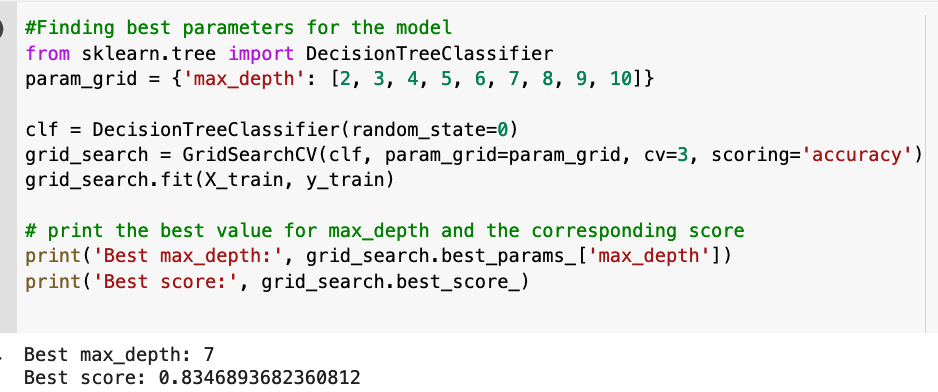

Based on that, we train the model with max_depth = 7 and report the metrics.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier(max_depth= 7, random_state=0)
dt.fit(X_train, y_train)

y_pred=dt.predict(X_test)

In [ ]:
dt_prec = precision_score(y_pred, y_test)
dt_recall = recall_score(y_pred, y_test)
dt_auc = roc_auc_score(y_pred, y_test)
dt_acc= dt.score(X_test, y_test)

print('Test Precision {}'.format(dt_prec))
print('Test Recall {}'.format(dt_recall))
print('Test AUC-ROC {}'.format(dt_auc))
print('Test Accuracy {}'.format(dt_acc))

Test Precision 0.04898965007392804
Test Recall 0.6460138648180243
Test AUC-ROC 0.7415935620968769
Test Accuracy 0.834723089952379


## Random Forest Classifier
Adding onto the Decision Tree Classification, the Random Forest Classifier can also be a useful algorithm to classify whether a crash involved injury or not due to its ability to handle large datasets with high dimensionality and noisy features. The model also has a low risk of overfitting and can provide feature importance scores, which can aid in understanding the most significant predictors of injury in a crash. Additionally, the ensemble nature of Random Forest Classifier can result in improved accuracy compared to decision trees.

In [ ]:
 #Random Forest requires no feature scaling or extensive parameter 
X = df[features_keep]
y = df['any_injuries']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
#Training model and reporting metrics
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_features = 8, random_state = 0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [ ]:
clf_prec = precision_score(y_pred, y_test)
clf_recall = recall_score(y_pred, y_test)
clf_auc = roc_auc_score(y_pred, y_test)
clf_acc= clf.score(X_test, y_test)

print('Test Precision {}'.format(clf_prec))
print('Test Recall {}'.format(clf_recall))
print('Test AUC-ROC {}'.format(clf_auc))
print('Test Accuracy {}'.format(clf_acc))

Test Precision 0.08270083785115821
Test Recall 0.38869585360203845
Test AUC-ROC 0.6139352349719027
Test Accuracy 0.822974717814153


## Classification Model Performance Summary 

To sum up the previous classification models that we ran, each with their best parameters identified through GridSearch, we provide the dataframe below, summarizing the evaluation metrics. 

In [ ]:
metrics_dict = {
    'Classifier Model': ['Linear SVM', 'Logistic', 'Decision Tree', 'Random Forest'],
    'Accuracy': [svm_acc, logreg_acc, dt_acc, clf_acc],
    'Precision': [svm_prec, logreg_prec, dt_prec, clf_prec],
    'Recall': [svm_recall, logreg_recall, dt_recall, clf_recall],
    'AUC ROC': [svm_auc, logreg_auc, dt_auc, clf_auc]
}

metrics = pd.DataFrame(metrics_dict)
metrics

,Classifier Model,Accuracy,Precision,Recall,AUC ROC
0,Linear SVM,0.832513,0.044176,0.557190,0.696721
1,Logistic,0.832493,0.031066,0.584183,0.709464
2,Decision Tree,0.834723,0.048990,0.646014,0.741594
3,Random Forest,0.822975,0.082701,0.388696,0.613935


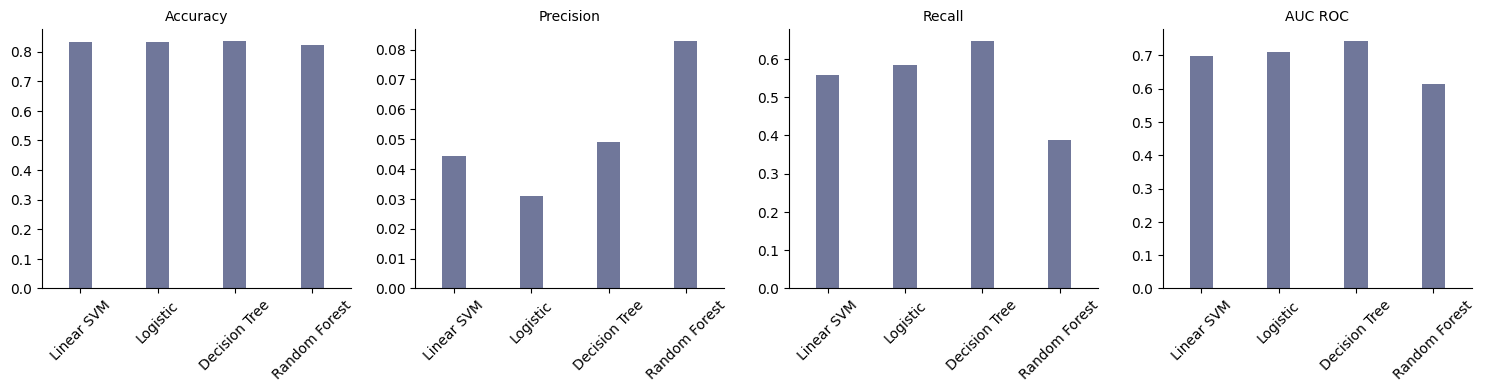

In [ ]:
# Make bar plots to visually compare the metrics
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize= (15, 4))
ax_ls = [ax1, ax2, ax3, ax4]

for n in range(len(ax_ls)):

  sns.barplot(ax = ax_ls[n], data=metrics, x= 'Classifier Model', y= list(metrics.columns)[n+1], color="#29387a", width=0.3, alpha=0.7)
  ax_ls[n].set_title(list(metrics.columns)[n+1], fontsize="medium")
  ax_ls[n].set_xticklabels(labels=['Linear SVM', 'Logistic', 'Decision Tree', 'Random Forest'], rotation=45)
  ax_ls[n].set_xlabel("")
  ax_ls[n].set_ylabel("")
   
sns.despine(fig)
fig.tight_layout(pad=1.0);

Based on the metrics shown above, it seems like the Decision Tree Classification model is the most appropriate. It has the highest accuracy, recall, and AUC ROC value. Therefore, we look at the effect of gender on this model. To do this, we build different "versions" of the Decision Tree classifier. We use the previous groupings of features to external factors, weather-related factors, vehicle-related factors and driver-related factors to try different combinations of these groups as features in the classification model. Our aim is to see the change in the behavior of the `sex` variable when we change which features are included/ excluded in the model. 

## Importance of driver's gender - Decision Tree Classification

In [ ]:
from sklearn.tree import DecisionTreeClassifier

sex= ['sex']
external= [j for j in features_keep if j in exfac_cols]
external_sex= [j for j in features_keep if j in exfac_cols] + sex
weather = [i for i in features_keep if i in weather_cols]
weather_sex = [i for i in features_keep if i in weather_cols] + sex
vehicles= [k for k in features_keep if k in vehicles_cols]
vehicles_sex=[ k for k in features_keep if k in vehicles_cols] + sex

person= ['age']
person_sex= ['age'] + sex

everything = external + weather + vehicles+person
everything_sex= everything + sex

list_classifiers= [everything, everything_sex, sex, external, external_sex, weather, weather_sex, vehicles, vehicles_sex, person, person_sex]

# DataFrame to report the metrics
results_df = pd.DataFrame()

# run different Decision Tree models
for i in list_classifiers:
    if i == sex:
        feature_name = 'Female'
    elif i == external:
        feature_name = 'External Factors'
    elif i == external_sex:
        feature_name = 'Female and External Factors'
    elif i == weather:
        feature_name = 'Weather Factors'
    elif i == weather_sex:
        feature_name = 'Female and Weather Factors'
    elif i == vehicles:
        feature_name = 'Vehicle Factors'
    elif i == vehicles_sex:
        feature_name = 'Female and Vehicle Factors'
    elif i == person:
        feature_name = 'Age'
    elif i == person_sex:
        feature_name = 'Female and Age'
    elif i==everything:
        feature_name = 'External, Weather, Vehicle Factors, and Age'
    elif i==everything_sex:
        feature_name = 'Female, External, Weather, Vehicle Factors, and Age'
        
    # define the X and y for each model
    X = df[i]
    y = df['any_injuries']

    # train, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    # Build a Decision tree classifier 
    dt=DecisionTreeClassifier(max_depth= 7, random_state=0)
    dt.fit(X_train, y_train)

    # Predict for test set
    y_pred=dt.predict(X_test)

    # Report metrics
    dt_accuracy = accuracy_score(y_test, y_pred)
    dt_recall = recall_score(y_test,y_pred)
    dt_auc = roc_auc_score(y_test,y_pred)
    dt_prec = precision_score(y_test, y_pred)

    # Report the evaluation metrics
    results_df = results_df.append({'Features': feature_name, 'Accuracy': dt_accuracy, 'Precision': dt_prec, 'Recall': dt_recall, 'AUC ROC': dt_auc}, ignore_index=True)

In [ ]:
results_df

,Features,Accuracy,Precision,Recall,AUC ROC
0,"External, Weather, Vehicle Factors, and Age",0.835146,0.647598,0.049355,0.521953
1,"Female, External, Weather, Vehicle Factors, an...",0.835149,0.647812,0.049328,0.521944
2,Female,0.831352,0.000000,0.000000,0.500000
3,External Factors,0.831352,0.000000,0.000000,0.500000
4,Female and External Factors,0.831352,0.000000,0.000000,0.500000
5,Weather Factors,0.831352,0.000000,0.000000,0.500000
6,Female and Weather Factors,0.831352,0.000000,0.000000,0.500000
7,Vehicle Factors,0.835149,0.647965,0.049289,0.521928
8,Female and Vehicle Factors,0.835151,0.648129,0.049276,0.521924
9,Age,0.831350,0.400000,0.000026,0.500009


From the dataframe above, we can compare pairs consisting of a model with certain features and another model with the same features along with `sex`. Including the `sex` variable generally increases accuracy, albeit by a very small value of 0.000002. However, considering that the dataset is huge, an increase of 0.000002 in accuracy might mean correctly predicting a lot more car crashes in numbers. Hence, `sex` seems to be an influential factor in this prediction.

Moreover, to assess the role of gender for the predicting whether crash involves injury or not, we do logistic regression and interpret the coefficients.

In [ ]:
sex=['sex']
external=[j for j in features_keep if j in exfac_cols]+sex
weather = [i for i in features_keep if i in weather_cols]+external
vehicles=[k for k in features_keep if k in vehicles_cols]+weather
person=['age']+vehicles

list_classifiers=[sex, external, weather, vehicles, person]

# Dataframe to report the evaluation metrics
results_df2= pd.DataFrame()

# Find coefficients from different Logistic Regression models
for i in list_classifiers:

      # Define X and y
      X = df[i]
      y = df['any_injuries']

      # Train-test split 
      X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


      if i=="vehicles":
        cont=['vehicle_age']
        binary=[i for i in features_keep if i not in cont]
        x_train_scaled = x_train.copy()
        x_test_scaled = x_test.copy()
        x_train_normal = pd.DataFrame(scaler1.fit_transform(x_train[cont]), columns=cont).reset_index(drop=True)
        x_train_binary=pd.DataFrame((x_train[binary]), columns=binary).reset_index(drop=True)
        x_train_scaled = pd.concat([x_train_normal, x_train_binary], axis=1).reset_index(drop=True)
        x_test_normal = pd.DataFrame(scaler1.transform(x_test[cont]), columns=cont).reset_index(drop=True)
        x_test_binary=pd.DataFrame((x_test[binary]), columns=binary).reset_index(drop=True)
        x_test_scaled = pd.concat([x_test_normal, x_test_binary], axis=1).reset_index(drop=True) 
        X_train=x_train_scaled 
        X_test=x_test_scaled
      elif i=="person":
        cont=['vehicle_age', 'age']
        binary=[i for i in features_keep if i not in cont]
        x_train_scaled = x_train.copy()
        x_test_scaled = x_test.copy()
        x_train_normal = pd.DataFrame(scaler1.fit_transform(x_train[cont]), columns=cont).reset_index(drop=True)
        x_train_binary=pd.DataFrame((x_train[binary]), columns=binary).reset_index(drop=True)
        x_train_scaled = pd.concat([x_train_normal, x_train_binary], axis=1).reset_index(drop=True)
        x_test_normal = pd.DataFrame(scaler1.transform(x_test[cont]), columns=cont).reset_index(drop=True)
        x_test_binary=pd.DataFrame((x_test[binary]), columns=binary).reset_index(drop=True)
        x_test_scaled = pd.concat([x_test_normal, x_test_binary], axis=1).reset_index(drop=True) 
        X_train=x_train_scaled 
        X_test=x_test_scaled
      else:
        X_train=X_train
        X_test=X_test
  
      # Build logistic regression models 
      logreg = LogisticRegression(penalty="l2", max_iter=1000, C=0.01)
      logreg.fit(X_train, y_train)

      # extract coefficient for sex feature
      sex_coefficient = logreg.coef_[0][0] 

      # Predict
      y_pred=logreg.predict(X_test)

      # Evaluation metrics 
      lr_accuracy = accuracy_score(y_test, y_pred)
      lr_recall = recall_score(y_test,y_pred)
      lr_auc = roc_auc_score(y_test,y_pred)
      lr_prec = precision_score(y_test, y_pred)

      feature_name = ', '.join(i)

      # Report metrics
      results_df2 = results_df2.append({'Feature': feature_name, 'Coefficient': sex_coefficient, 'Accuracy': lr_accuracy, 'Precision': lr_prec, 'Recall': lr_recall, 'AUC ROC': lr_auc}, ignore_index=True)

# add Feature column values
results_df2.loc[0, 'Feature'] = 'Female'
results_df2.loc[1, 'Feature'] = 'Female and External Factors'
results_df2.loc[2, 'Feature'] = 'Female, External and Weather Factors'
results_df2.loc[3, 'Feature'] = 'Female, External, Weather and Vehicle Factors'
results_df2.loc[4, 'Feature'] = 'Female, External, Weather, Vehicle Factors and Age'


In [ ]:
results_df2

,Feature,Coefficient,Accuracy,Precision,Recall,AUC ROC
0,Female,0.046335,0.831352,0.000000,0.000000,0.500000
1,Female and External Factors,0.509353,0.831352,0.000000,0.000000,0.500000
2,"Female, External and Weather Factors",-0.012235,0.831352,0.000000,0.000000,0.500000
3,"Female, External, Weather and Vehicle Factors",0.015973,0.832925,0.585590,0.031902,0.513661
4,"Female, External, Weather, Vehicle Factors and...",-0.002632,0.832858,0.583374,0.031243,0.513359


Here, we have 5 versions of the logistic regression model. Among these, we choose the fourth model with Female, External, Weather and Vehicle factors as features. This model has the highest accuracy, precision, recall and AUC ROC, so we can reliably say that this model is the best predictor. The coefficient of `sex` in this model is a positive value of 0.015973, so we can say that `sex` has a positive effect on causing injuries in a car crash.

# Conclusion

In this Milestone, we continued the exploratory data analysis. We re-defined our dependent variable to reflect the severity of injuries, thus allowing us to use it as a proxy for the severity of car crashes. Examining the features and the dummy variables derived from the categorical features, we performed feature selection to choose the most relevant independent variables. 

With these features, we performed various supervised machine learning models of regression and classification. However, even with the regression model with the best performance (Linear SVM Regression), the accuracy was quite low. This suggests that the set of features here are not apt to accurately predict the severity of injuries caused in car crashes. 

However, the dataset *was* suitable for predicting whether or not a car crash will result in any injuries, as our classification models generally performed well. The classification model with the best performance was the Decision Tree model. Hence, we used this model to focus specifically on the role of the driver's gender. We found that including the `sex` variable increased the performance of the classification model and hence it can be considered an important variable in predicting whether a crash will result in an injury.

Moreover, the results from the logistic regression model suggests that female drivers are likely to cause car crashes with injuries, compared to non-female drivers. Hence, while driver's gender is not a highly influential predictor of injury, there is evidence that female drivers likely cause more injuries. 

So far, our analysis confirms our hypothesis that the driver's gender influences injury rate in a car crash. More specifically, we find that `sex` is an influential variable in predicting whether there will be any injuries or not, but not necessarily in predicting the severity of injuries. 